<a href="https://colab.research.google.com/github/doublelei/16726Project/blob/main/render_AGORA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

## Import modules

In [2]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [3]:
# We also install chumpy as it is needed to load the SMPL model pickle file.
!pip install smplx[all]

In [9]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import smplx

# libraries for reading data from files
from scipy.io import loadmat
from PIL import Image
import pickle

# Data structures and functions for rendering
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    Textures
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [5]:
!pip install --upgrade --no-cache-dir gdown
!gdown https://drive.google.com/drive/folders/18uW2COwfs5Y2qEzFXPpqpU4wYKYzHLbO -O . --folder
!unzip ./models_smplx_v1_1.zip

Retrieving folder list
Processing file 1IBVu5GPGYKuPYYlJImlhqEfFFab0s1Ie 10004_w_Amaya_0_0.pkl
Processing file 1KxXN-bt3KzTIOru9I6nRXfRxn4zxJ73C ag_trainset_renderpeople_bfh_archviz_5_10_cam02_00000_1280x720.png.npz
Processing file 1Dp_dW8nt6blnIAq9u6tgM3PuCH5_0AEg models_smplx_v1_1.zip
Processing file 1GVrzqnnZ53a4ZpNsjMFiucnw753sIfzH smplx_uv.obj
Processing file 1WtJa2rI5qzSJF8DQmIUu8NBo-5BQxede smplx_uv.png
Processing file 1XTHke2VybnTj6_qYzY9HgsZ_dYure3r- texture.png
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1IBVu5GPGYKuPYYlJImlhqEfFFab0s1Ie
To: /content/10004_w_Amaya_0_0.pkl
100% 254k/254k [00:00<00:00, 96.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KxXN-bt3KzTIOru9I6nRXfRxn4zxJ73C
To: /content/ag_trainset_renderpeople_bfh_archviz_5_10_cam02_00000_1280x720.png.npz
100% 1.29M/1.29M [00:00<00:00, 45.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=

In [6]:
model = smplx.create('./models', 'smplx', use_pca=False)
with open('./Aec0003-HD2-O01P01-S_0_0.pkl', 'rb') as f:
    gt = pickle.load(f, encoding='latin1') 
print(gt.keys())

dict_keys(['betas', 'global_orient', 'transl', 'left_hand_pose', 'right_hand_pose', 'jaw_pose', 'leye_pose', 'reye_pose', 'expression', 'body_pose', 'keypoints_3d', 'pose_embedding', 'gender', 'v'])


In [7]:
num_betas = 10
smplx_gt = model(
        betas=torch.tensor(gt['betas'][:, :num_betas], dtype=torch.float), 
        global_orient=torch.tensor(gt['global_orient'], dtype=torch.float),
        body_pose=torch.tensor(gt['body_pose'], dtype=torch.float),
        left_hand_pose=torch.tensor(gt['left_hand_pose'], dtype=torch.float),
        right_hand_pose=torch.tensor(gt['right_hand_pose'], dtype=torch.float),
        transl=torch.tensor(gt['transl'], dtype=torch.float),
        expression=torch.tensor(gt['expression'], dtype=torch.float), 
        jaw_pose=torch.tensor(gt['jaw_pose'], dtype=torch.float),
        leye_pose=torch.tensor(gt['leye_pose'], dtype=torch.float),
        reye_pose=torch.tensor(gt['reye_pose'], dtype=torch.float), pose2rot=True)

In [10]:
verts, faces, aux = load_obj("./smplx_uv.obj")
verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
tex_maps = aux.texture_images

with Image.open('./texture.png') as image:
    np_image = np.asarray(image.convert("RGB")).astype(np.float32)
texture_images = torch.from_numpy(np_image / 255.)[None].to(device)

# Create a textures object
tex = Textures(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_images)
# Initialise the mesh with textures
meshes = Meshes(verts=[smplx_gt.vertices.squeeze().to(device)], faces=[faces.verts_idx.to(device)], textures=tex).to(device)

### Need to figure out how to combine the caramer parameter to the rendering:

In [14]:
# Initialize a camera.
# World coordinates +Y up, +X left and +Z in.
R, T = look_at_view_transform(5, 0, 0) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the person. 
lights = PointLights(device=device, location=[[0.0, 0.0, 2.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

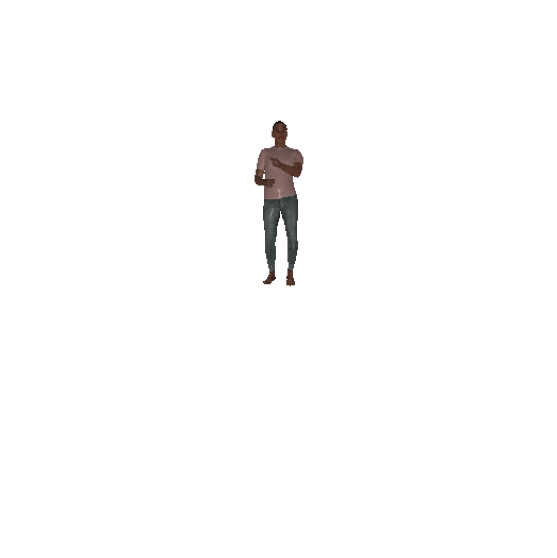

In [15]:
images = renderer(meshes.to(device), lights=lights.to(device), cameras=cameras.to(device))
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].detach().cpu().numpy())
plt.axis("off");